# Lab: Aprendizaje por refuerzo (II)
# 7 - Cartpole

## Configuración y dependencias

In [2]:
!pip install gymnasium seaborn numpy pygame

import gymnasium as gym
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import abc
import numpy as np
import random

Defaulting to user installation because normal site-packages is not writeable


In [3]:
def draw_history(history, title):
    window_size = 50
    data = pd.DataFrame({'Episode': range(1, len(history) + 1), title: history})
    data['rolling_avg'] = data[title].rolling(window_size).mean()
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y=title, data=data)
    sns.lineplot(x='Episode', y='rolling_avg', data=data)

    plt.title(title + ' Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel(title)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

Vamos a copiar la definición de la clase de agente de aproximación lineal ya que la vamos a usar más adelante en este notebook:

In [4]:
class LinearApproximationAgent(metaclass=abc.ABCMeta):
    def __init__(self, state_dimensions, action_space, learning_rate, discount_factor, epsilon, seed):
        self.weights = np.zeros((state_dimensions + 1, action_space))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_space = action_space
        self.rng = random.Random(seed)

    def choose_action(self, state, training=True):
        if training and self.rng.random() < self.epsilon:
            return self.rng.choice(range(self.action_space))
        features = self.extract_features(state)
        q_values = np.dot(features, self.weights)
        return np.argmax(q_values)

    def update_weights(self, state, action, reward, next_state, done):
        features = self.extract_features(state)
        next_features = self.extract_features(next_state)
        q_values_next = np.dot(next_features, self.weights)
        best_next_action = np.argmax(q_values_next)
        td_target = reward + self.discount_factor * q_values_next[best_next_action] * (not done)
        td_error = td_target - np.dot(features, self.weights[:,action])
        self.weights[:,action] += self.learning_rate * td_error * features
        return td_error

    @abc.abstractmethod
    def extract_features(self, state):
        pass

## Entorno Cartpole

En este notebook vamos a dejar a un lado el entorno FrozenLake y vamos a probar un entorno bastante diferente: CartPole.

Dedica unos minutos a aprender en qué consiste el entorno Cartpole en [la web de Gymnasium](https://gymnasium.farama.org/environments/classic_control/cart_pole/), poniendo especial atención a cómo se representan las observaciones.

La diferencia principal con respecto a FrozenLake es que CartPole **tiene un espacio de estados continuo**, compuesto por cuatro variables asimismo continuas. ¿Significa esto que no hay un MDP subyacente a esta tarea? No, para nada. Los elementos principales de un MDP son la función de transición y la función de recompensa. La función de transición es una distribución de probabilidad (y es por este motivo que, por claridad, en general se suele ver más la formalización `p(s'|s,a)` que `T(s,a,s')`), y como tal se puede aplicar a un estado de un espacio continuo. De manera análoga, la función de recompensa puede seguir siendo una función sobre s, a y s' siendo los tres elementos potencialmente también continuos.

Sí que es cierto que no podremos formalizar un MDP sobre un espacio discreto y su representación análoga como un grafo, como hemos visto en teoría. Sin embargo, si somos capaces de representar de manera computacional estas funciones sobre espacios contiguos vamos a poder seguir utilizando algoritmos value-based como Q-Learning, y eso lo podremos hacer reimplementando el método `extract_features` sobre la clase que habíamos definido en el notebook anterior:

In [5]:
class ContinuousStateLinearApproximationAgent(LinearApproximationAgent):
    def __init__(self, state_dimensions, action_space, learning_rate=0.01, discount_factor=0.99,
                 epsilon=0.2, seed=42):
        super().__init__(state_dimensions, action_space, learning_rate, discount_factor, epsilon, seed)
        self.max_states = state_dimensions

    def extract_features(self, state):
        return np.append(state, 1)

Es decir, vamos a considerar que el estado se representa tal y como viene del entorno: como un vector de cuatro variables continuas (revisad la documentación del entorno si es necesario). Recordad que para FrozenLake teníamos vectores one-hot para identificar el estado como un valor discreto en un vector con el tamaño de la cardinalidad del conjunto de estados. En este caso, lo que identifica al estado (sus _features_ o características) son las cuatro variables definidas en la implementación del entorno.

En definitiva, al crear `LinearApproximationAgent` hemos definido una clase de agente que generaliza el algoritmo Q-Learning para el caso general, incluyendo entornos discretos y continuos.

Vamos a entrenar CartPole sin variar cómo lo hicimos para FrozenLake:

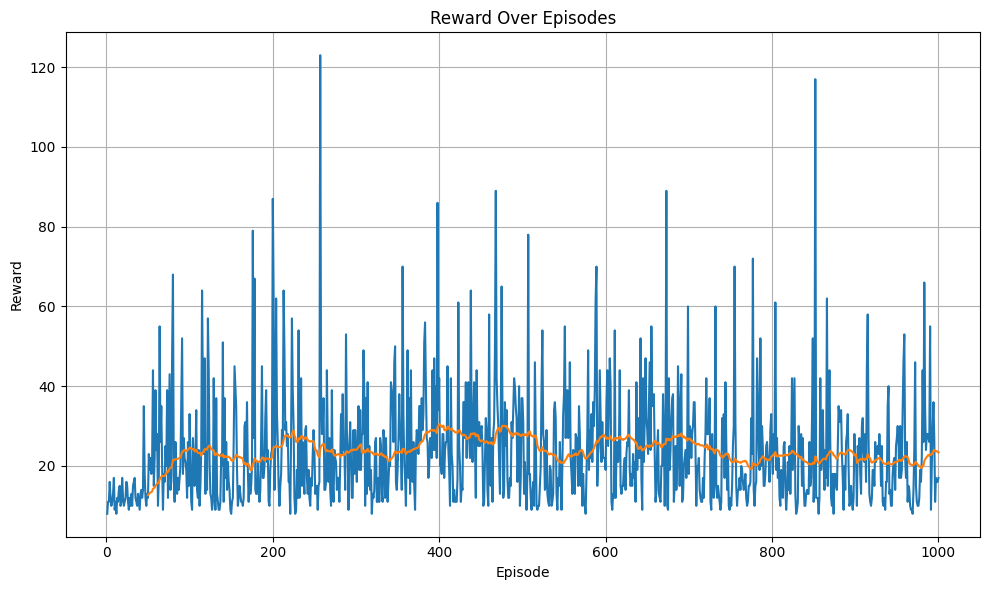

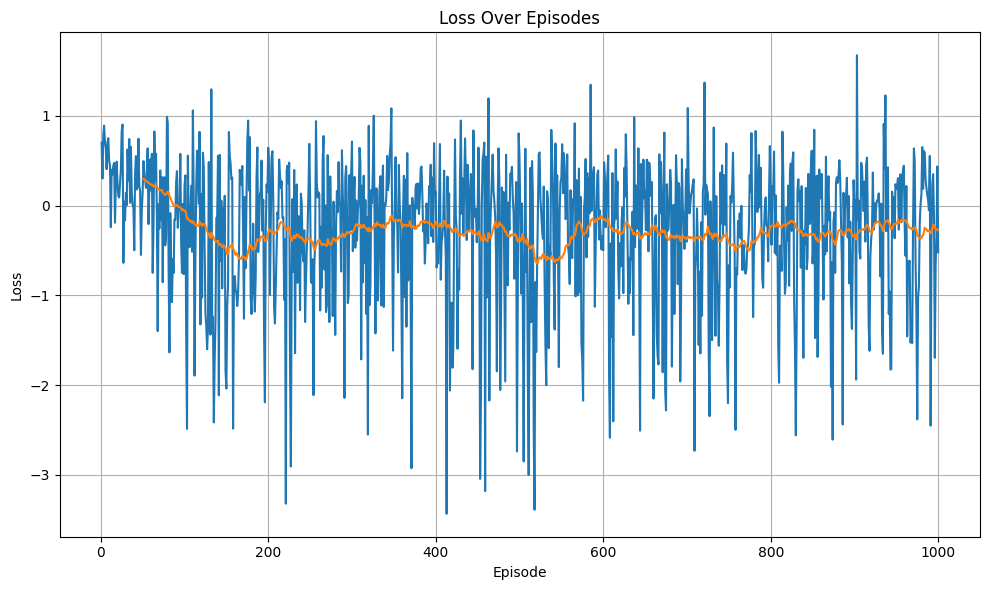

In [6]:
env_cartpole = gym.make('CartPole-v1')
agent_cartpole = ContinuousStateLinearApproximationAgent(
    env_cartpole.observation_space.shape[0], env_cartpole.action_space.n,
    learning_rate=0.1, epsilon=0.2, discount_factor=0.99, seed=0)

rewards = []
losses = []
for episode in range(1000):
    state, _ = env_cartpole.reset()
    done = False
    total_reward = 0
    sum_losses = 0
    steps = 0

    while not done:
        action = agent_cartpole.choose_action(state)
        next_state, reward, done, terminated, _ = env_cartpole.step(action)
        sum_losses = sum_losses + agent_cartpole.update_weights(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        steps = steps + 1

    losses.append(sum_losses / steps)
    rewards.append(total_reward)

draw_history(rewards, 'Reward')
draw_history(losses, 'Loss')

Vamos a comprobar el rendimiento del agente resultante viéndolo en una UI:

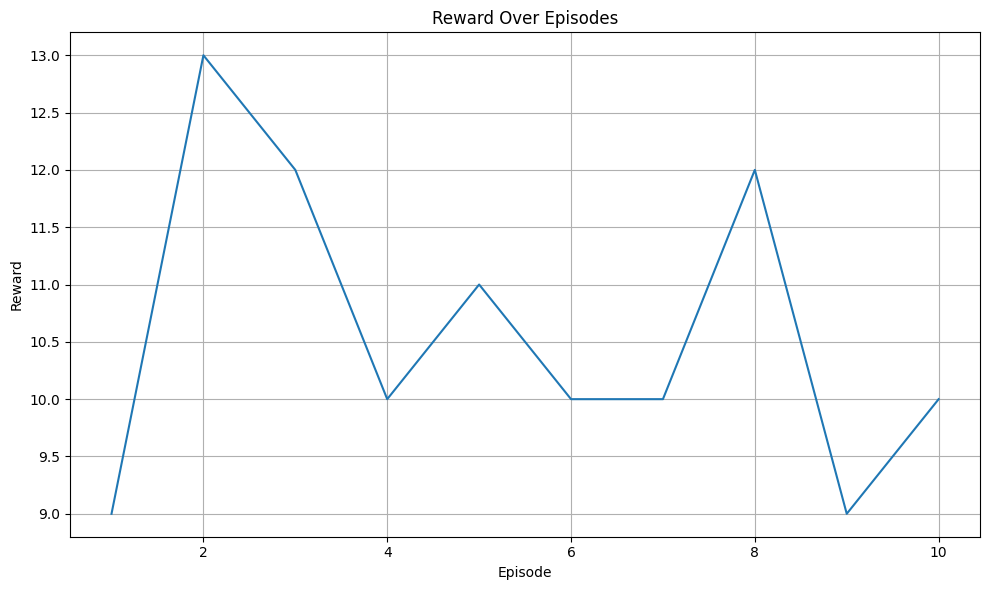

Mean reward: 10.6


: 

In [6]:
rewards = []
env_cartpole_render = gym.make('CartPole-v1', render_mode='human')
for episode in range(10):
    state, _ = env_cartpole_render.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent_cartpole.choose_action(state, training=False)
        next_state, reward, done, terminated, _ = env_cartpole_render.step(action)
        env_cartpole_render.render()
        state = next_state
        total_reward += reward

    rewards.append(total_reward)

draw_history(rewards, 'Reward')
print(f"Mean reward: {np.mean(rewards)}")

La recompensa media no parece muy alta, ya que la máxima es de 500 (revisad la documentación).

**Jugad con los parámetros, a ver hasta qué utilidad media llegáis.**

Muy probablemente no lleguéis muy lejos. El problema principal es este:

In [7]:
agent_cartpole.weights

array([[ 5.19775918, -9.90871515],
       [19.07499387, -9.51712125],
       [-0.17524901,  7.26393041],
       [ 8.91661398,  2.79009844],
       [17.86743544, 22.72397406]])

Las interacciones entre las cuatro variables y el comportamiento del carro no pueden ser adecuadamente modeladas mediante aproximaciones lineales, ya que la relación entre estas variables es seguramente no lineal.

Por ejemplo: supongamos que el poste está casi vertical pero con una pequeña inclinación hacia la derecha y además tiene una velocidad angular que lo dirige más hacia la derecha. Instintivamente, mover el carro hacia la derecha podría parecer correcto para contrarrestar la caída. Sin embargo, dependiendo de las magnitudes concretas de la velocidad angular y la posición actual del carro, una rápida aceleración hacia la izquierda podría ser más efectiva (esto puede parecer contraintuitivo pero se debe al hecho de que el poste funciona como un "péndulo invertido", se nos escapa por temática pero si tenéis curiosidad podéis leer más sobre esto [aquí](https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling)).

En consecuencia, para capturar mediante aprendizaje la complejidad de este comportamiento, necesitamos modelos que incluyan la posibilidad de capturar esta no linearidad. Por ejemplo, podemos usar redes neuronales:

In [8]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.weights2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)

    def forward(self, x):
        self.z1 = np.dot(x, self.weights1)
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.weights2)
        return softmax(self.z2)

    def backward(self, x, y, o, learning_rate):
        output_error = y - o
        output_delta = output_error

        hidden_error = output_delta.dot(self.weights2.T)
        hidden_delta = hidden_error * relu_derivative(self.a1)

        self.weights2 += self.a1.T.dot(output_delta) * learning_rate
        self.weights1 += x.T.dot(hidden_delta) * learning_rate

class NonLinearApproximationAgent:
    def __init__(self, state_dimensions, action_space, learning_rate, discount_factor, epsilon, hidden_size, seed):
        self.network = NeuralNetwork(state_dimensions, hidden_size, action_space)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_space = action_space
        self.rng = random.Random(seed)

    def select_action(self, state, training=True):
        if training and self.rng.random() < self.epsilon:
            return self.rng.choice(range(self.action_space))
        state = np.array(state).reshape(1, -1)
        q_values = self.network.forward(state)
        return np.argmax(q_values)

    def update_weights(self, state, action, reward, next_state, done):
        state = np.array(state).reshape(1, -1)
        next_state = np.array(next_state).reshape(1, -1)
        q_values_next = self.network.forward(next_state)
        best_next_action = np.argmax(q_values_next)

        td_target = reward + self.discount_factor * q_values_next[0, best_next_action] * (not done)
        q_values = self.network.forward(state)
        target_output = q_values.copy()
        target_output[0, action] = td_target

        self.network.backward(state, target_output, q_values, self.learning_rate)

        td_error = np.abs(td_target - q_values[0, action])
        return td_error

Esta implementación es poco eficiente, pero nos sirve para ejemplificar. Como nuevo parámetro a modificar, tenéis el tamaño de la capa intermedia de la red neuronal, es decir, en cuantas características (_features_) queremos convertir las cuatro variables de entrada para capturar el comportamiento. Un número demasiado bajo puede dar lugar a no poder capturar suficientemente la complejidad, y un número demasiado alto puede provocar _overfitting_ y que el agente en realidad no aprenda un comportamiento estable.

**Probad con diferentes valores de las variables a ver hasta dónde podéis empujar la utilidad obtenida.** Os costará llegar a valores cercanos al óptimo, pero debería ser fácil obtener consistentemente mejores resultados que con el modelo lineal.

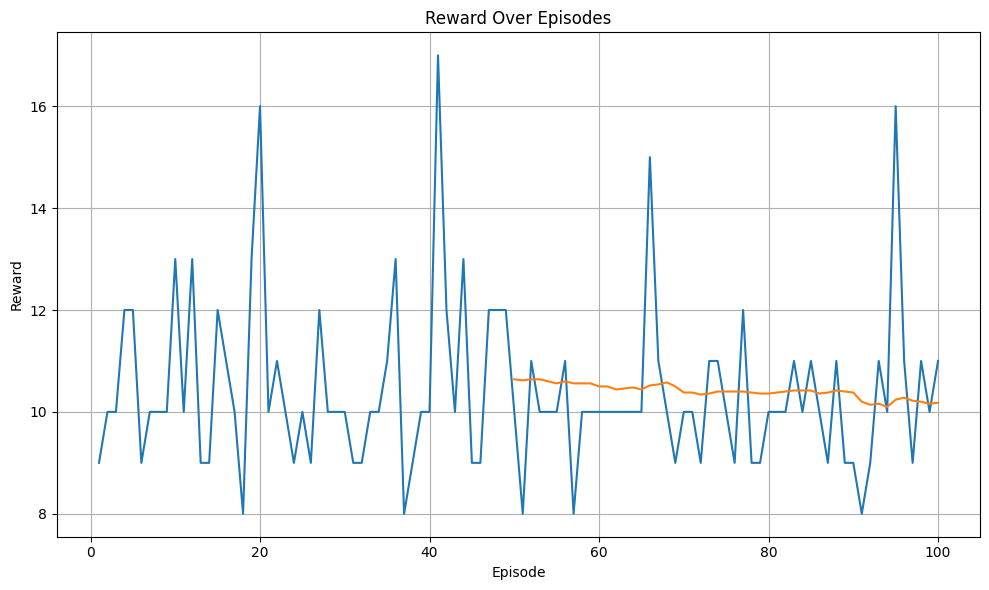

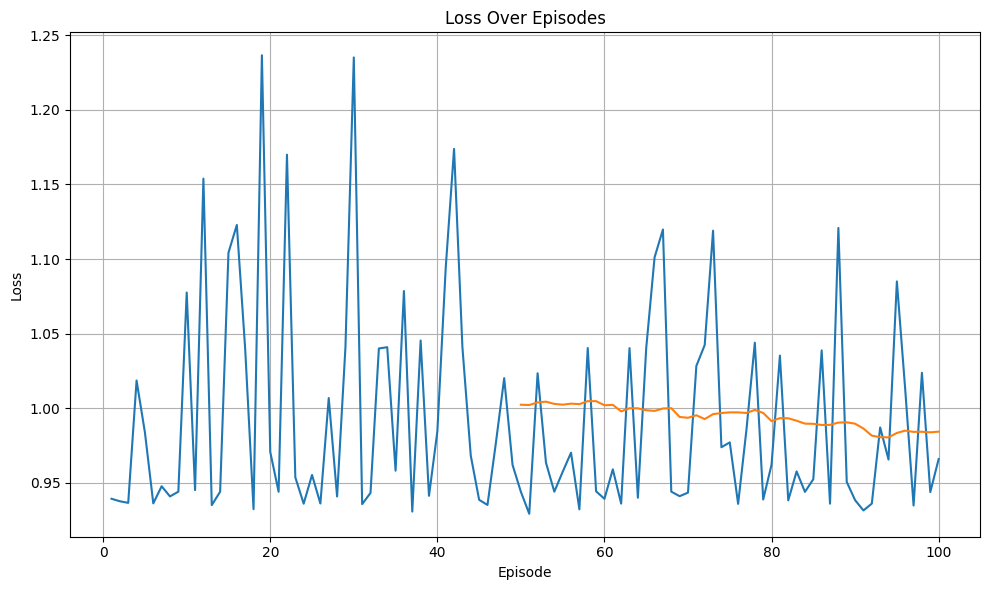

In [9]:
env_cartpole = gym.make('CartPole-v1')
agent_cartpole = NonLinearApproximationAgent(
    env_cartpole.observation_space.shape[0], env_cartpole.action_space.n,
    learning_rate=0.0001, epsilon=0.2, discount_factor=0.99, hidden_size=8, seed=0)

rewards = []
losses = []
for episode in range(100):
    state, _ = env_cartpole.reset()
    done = False
    total_reward = 0
    sum_losses = 0
    steps = 0

    while not done:
        action = agent_cartpole.select_action(state)
        next_state, reward, done, terminated, _ = env_cartpole.step(action)
        sum_losses = sum_losses + agent_cartpole.update_weights(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        steps = steps + 1

    losses.append(sum_losses / steps)
    rewards.append(total_reward)

draw_history(rewards, 'Reward')
draw_history(losses, 'Loss')

Código para evaluar el agente:

In [ ]:
rewards = []
env_cartpole_render = gym.make('CartPole-v1', render_mode='human')
for episode in range(10):
    state, _ = env_cartpole_render.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent_cartpole.select_action(state, training=False)
        next_state, reward, done, terminated, _ = env_cartpole_render.step(action)
        env_cartpole_render.render()
        state = next_state
        total_reward += reward

    rewards.append(total_reward)

draw_history(rewards, 'Reward')
print(f"Mean reward: {np.mean(rewards)}")

## Por dónde continuar

Hasta ahora hemos visto cómo se implementan, de manera básica, los algoritmos de aprendizaje por refuerzo. A partir del punto al que hemos llegado sólo queda:

* Aplicar algoritmos más modernos pero también bastante más complejos, como A3C, DQN o PPO.
* Definir modelos más complejos para capturar las características del entorno, como por ejemplo redes neuronales profundas. Esto puede incluir, por ejemplo, que el entorno sea una matriz representando una imagen en RGB.

Lo positivo de esto es que hay muchas librerías ya programadas que nos pueden ahorrar gran parte del trabajo, y casi todas se integran con la librería de Gymnasium que habéis estado usando para la interacción con el entorno. Algunos ejemplos que podéis explorar son:

* [Stable Baselines](https://stable-baselines3.readthedocs.io/en/master/)
* [RLlib](https://docs.ray.io/en/latest/rllib/index.html)
* [CleanRL](https://github.com/vwxyzjn/cleanrl)